# Forecasting American Energy Consumption on hourly basis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

def mean_absolute_percenatge_error(y_true, y_predict):
    """Calculate mean absolute percenatage error (MAPE) given y_true, y_predict"""
    y_true, y_predict = np.array(y_true), np.array(y_predict)
    return np.mean(np.abs((y_true - y_predict) / y_true)) * 100

In [2]:
url_E = '/kaggle/input/hourly-energy-consumption/PJME_hourly.csv'
df_E = pd.read_csv(url_E)
df_E
url_W = '/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv'
df_W = pd.read_csv(url_W)

In [3]:
df_E = df_E.set_index('Datetime')
df_W = df_W.set_index('Datetime')
df_E.index = pd.to_datetime(df_E.index)
df_W.index = pd.to_datetime(df_W.index)

In [4]:
df = df_E.merge(df_W, how='inner', left_index=True, right_index= True)
df.head()

,PJME_MW,PJMW_MW
Datetime,,
2002-04-01 01:00:00,21734.0,4374.0
2002-04-01 02:00:00,20971.0,4306.0
2002-04-01 03:00:00,20721.0,4322.0
2002-04-01 04:00:00,20771.0,4359.0
2002-04-01 05:00:00,21334.0,4436.0


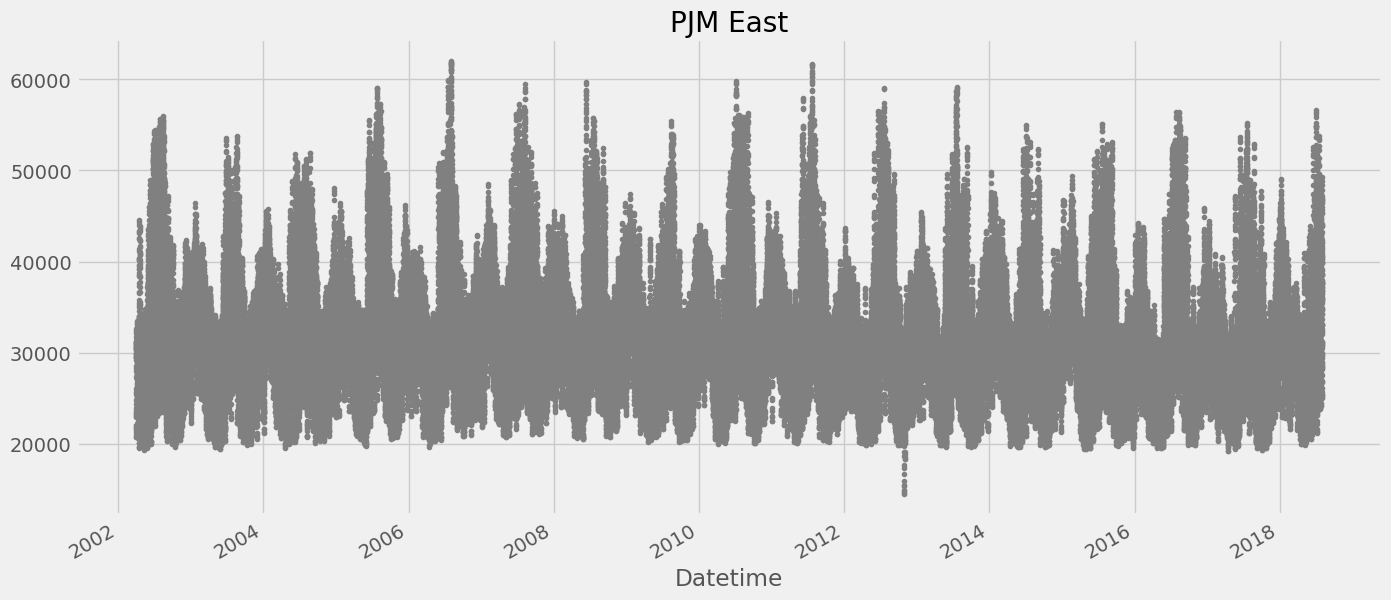

In [5]:
df['PJME_MW'].plot(style='.', figsize=(15,7), legend=False, color='grey', title='PJM East')
plt.show()

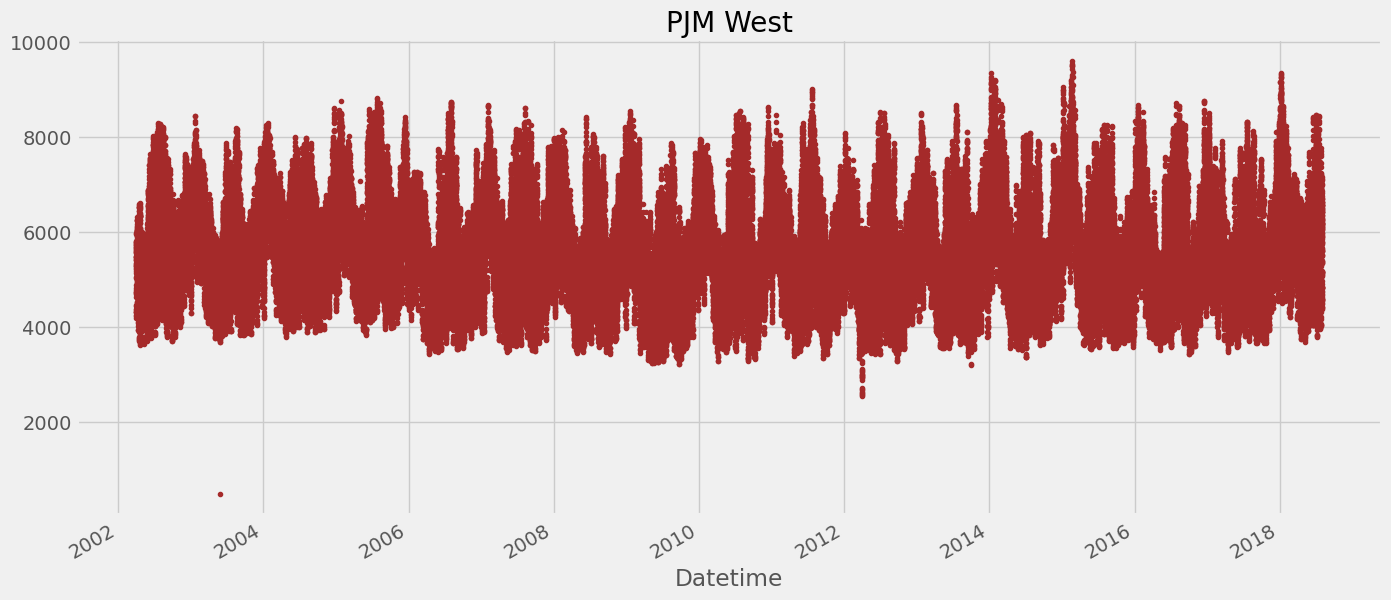

In [6]:
df['PJMW_MW'].plot(style='.', figsize=(15,7), legend=False, color='brown', title='PJM West')
plt.show()

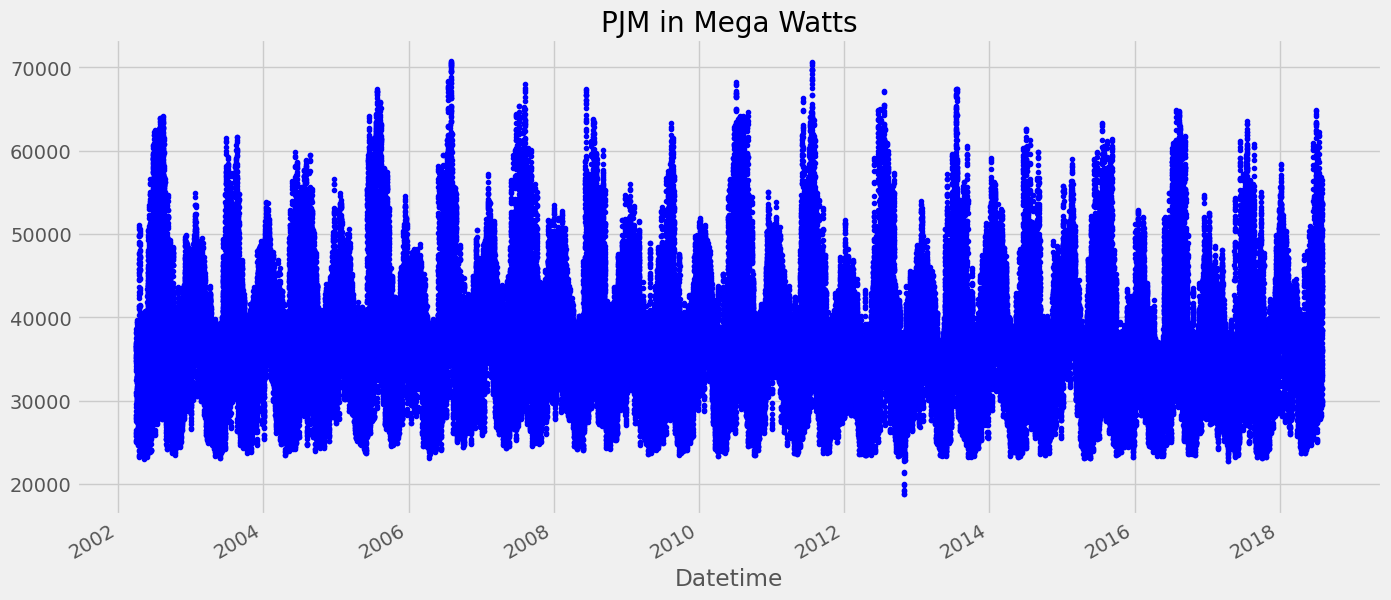

In [7]:
df['PJM_MW'] = df['PJME_MW'] + df['PJMW_MW']
df['PJM_MW'].plot(style='.', title='PJM in Mega Watts', color='blue', figsize=(15,7))
plt.show()

## Create time series features to interact with the PJM data.

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)


def create_features(df, label = None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df['date'].dt.month*100 + df['date'].dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], bins=[0, 300, 602, 900, 1300],
                         labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['hour', 'weekday', 'month',
            'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear',
            'season']]
    if label:
        y=df[label]
        return X, y
    return X
X, y = create_features(df, label='PJM_MW')
features_and_target = pd.concat([X, y], axis=1)
    

In [9]:
features_and_target.head()

,hour,weekday,month,year,quarter,dayofyear,dayofmonth,weekofyear,season,PJM_MW
Datetime,,,,,,,,,,
2002-04-01 01:00:00,1,Monday,4,2002,2,91,1,14,Spring,26108.0
2002-04-01 02:00:00,2,Monday,4,2002,2,91,1,14,Spring,25277.0
2002-04-01 03:00:00,3,Monday,4,2002,2,91,1,14,Spring,25043.0
2002-04-01 04:00:00,4,Monday,4,2002,2,91,1,14,Spring,25130.0
2002-04-01 05:00:00,5,Monday,4,2002,2,91,1,14,Spring,25770.0


## Plotting the trend of certain features

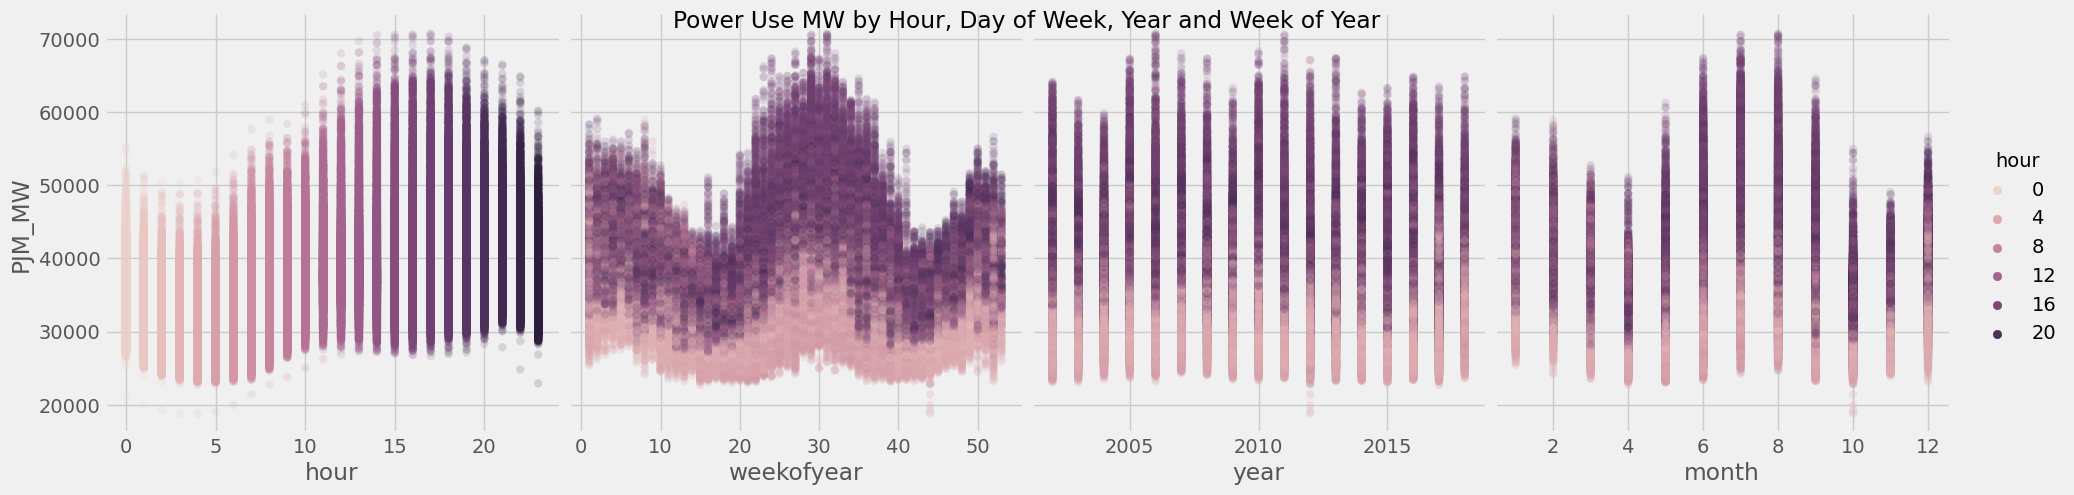

In [10]:
sns.pairplot(data=features_and_target, x_vars=['hour', 'weekofyear', 'year', 'month']
             , y_vars=['PJM_MW'], hue='hour',
             height=5, plot_kws={'alpha':0.15, 'linewidth':0})

plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()